In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.arange(0, 100).view(10, 10)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [3]:
# These are indicies into a discrete structure with 4 values.

X = torch.arange(0, 2) * 2 + torch.arange(0, 2).unsqueeze(1) 
X

tensor([[0, 2],
        [1, 3]])

In [4]:
# Suppose these are the 4 embeddings, each as row vectors.
C = torch.tensor([[1, 11], [2, 12], [3, 13], [4, 14]])
print(C)

# we can basically use the structure of X and index into C.
# For each index in C, we can replace the index with the value in C at the index.
C[X]

tensor([[ 1, 11],
        [ 2, 12],
        [ 3, 13],
        [ 4, 14]])


tensor([[[ 1, 11],
         [ 3, 13]],

        [[ 2, 12],
         [ 4, 14]]])

In [5]:
# Now we can flatten the structure: "unbind" the embedding dimension and concatenate them
print(torch.unbind(C[X], 1))
torch.cat(torch.unbind(C[X], 1), 1)

(tensor([[ 1, 11],
        [ 2, 12]]), tensor([[ 3, 13],
        [ 4, 14]]))


tensor([[ 1, 11,  3, 13],
        [ 2, 12,  4, 14]])

In [6]:
# Now we can flatten the structure: "unbind" the embedding dimension and concatenate them
C[X].view(-1, 4)

tensor([[ 1, 11,  3, 13],
        [ 2, 12,  4, 14]])

Idea: every token corresponds to an n dimensional embedding
> "Fighting the curse of dimensionality with distributed representations"

Because tokens/words are embedded a shared high dimensional space, this allows "smoothing" for inputs out of distribution, aka combinations never encountered before.
Similar inputs will result in more similar outputs.

> "learned distributed feature vector"



With n-gram models, context scales exponentially. Base: # of tokens. Exponent: length of context. So we never go beyond bigram/trigram.
With MLP, context scales linearly. 

bengio et all used a 30-dimensional embedding for 17k words
karpathy used a 2 dimensional embedding for 27 tokens (26 + start/end token).

in the previous network we simply indexed into a single 27*27 matrix that when multiplied produced next token probabilties.

now we translate characters aka indicies into embeddings.

27*n matrix of indicies


- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2


In [7]:
# read in all the words
words = open('makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Reinit here!


In [10]:
block_size = 5 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y



Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [11]:
Xtr[:10]

tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 25],
        [ 0,  0,  0, 25, 21],
        [ 0,  0, 25, 21,  8],
        [ 0, 25, 21,  8,  5],
        [25, 21,  8,  5, 14],
        [21,  8,  5, 14,  7],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  4],
        [ 0,  0,  0,  4,  9]])

In [343]:
W1_n = 200
t_d = 12
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, t_d), generator=g)
W1 = torch.randn((t_d * block_size, W1_n), generator=g) * 0.01
# W1 = torch.ones((t_d * block_size, W1_n))
b1 = torch.randn(W1_n, generator=g) * 0.01
# b1 = torch.zeros(W1_n)
W2 = torch.randn((W1_n, 27), generator=g) * 0.01
# W2 = torch.ones((W1_n, 27)) * 0.1
# b2 = torch.randn(27, generator=g)
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]

In [344]:
sum(p.nelement() for p in parameters) # number of parameters in total


17951

In [345]:
for p in parameters:
  p.requires_grad = True

In [346]:
# learning-rate exponent
lre = torch.linspace(-3, 0, 1000)

# learing-rate step
lrs = 10**lre

In [347]:
lri = []
lossi = []
stepi = []

In [348]:
Xtr.shape[0]

182625

In [349]:
# Batch indicies
ix = torch.randint(0, Xtr.shape[0], (32,))
ix

tensor([  8386,  80014, 145444,  84577, 121667, 118311, 106817, 146102,  28366,
        140090,  27651,  82453,  92054,  27448,  13758,  97246,  72662, 109261,
        172284,  27197,  27936,  79865,  86902, 157288,  78441,  13501, 181339,
        153635,  44643,  10582, 170227,   6120])

In [350]:
# Get context from indicies
Xtr[ix][:10]

tensor([[ 0,  0,  0,  1, 14],
        [ 0,  0,  0, 16, 18],
        [ 0,  5, 21, 12,  1],
        [ 0,  0, 26,  1,  4],
        [ 0,  0,  0, 11,  1],
        [ 8,  1, 18, 16,  5],
        [26,  1, 25, 12,  5],
        [ 4,  1, 12,  9,  1],
        [ 2, 18,  9,  5, 12],
        [ 0,  0,  6,  5, 18]])

In [365]:
for i in range(400000):
  
  # minibatch construct
  # Take 32 random sequences from training set.
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass

  # Xtr[ix] adds context ("get context at list index ix"). ix is list of sample indicies.
  # C[Xtr[ix]] adds embedding ("get embedding at token index xtr"). Xtr[ix] is list of token indicies.

  emb = C[Xtr[ix]] # (32, 3, 10)

  # emb.view: We collapse the embedding tensor dimension
  # and get a (32, 30) tensor

  # 32 items in "30 dimensional space"

  # which we multiply by weights W1 (30, 200) (30 rows, 200 columns)
  # to get a (32, 200) tensor
  h = torch.tanh(emb.view(-1, t_d * block_size) @ W1 + b1) # (32, 200)

  # Idea:
  # We're lifing up the 32 items to "200 dimensional space"

  # And then We multiply by W2 (200, 27) to get prediction back.
  # Idea: we project back down to "27-dimensional space".
  # These two determine a "probability function" for these 30-dimensional token embeddings (which we're simultaneously learning).
  logits = h @ W2 + b2 # (32, 27)

  # Finally we compute probabilities and see how well that models the output data
  # log it, and invert it.
  loss = F.cross_entropy(logits, Ytr[ix], label_smoothing=0.00) 

  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  lr = lr  if i < 200000 else 0.001
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  # lossi.append(loss.log10().item())
  lossi.append(loss.log10().item())

#print(loss.item())


In [352]:
h.shape

torch.Size([32, 200])

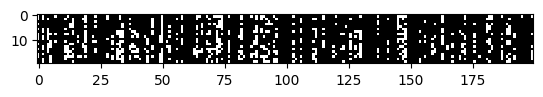

In [353]:
plt.imshow(h[:20].abs() > 0.99, cmap='gray', interpolation='nearest');

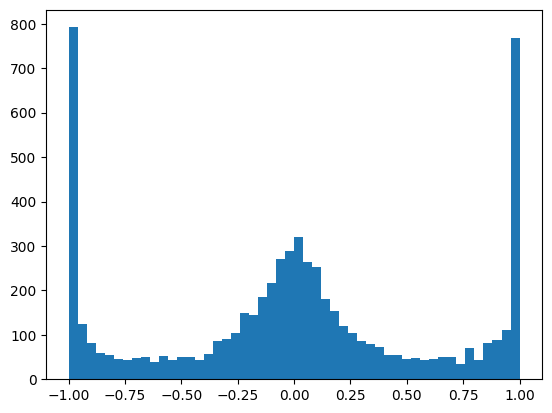

In [354]:
plt.hist(h.view(-1).tolist(), 50 );

In [355]:
import numpy as np
np.power(10, lossi[0])

3.2963201994241977

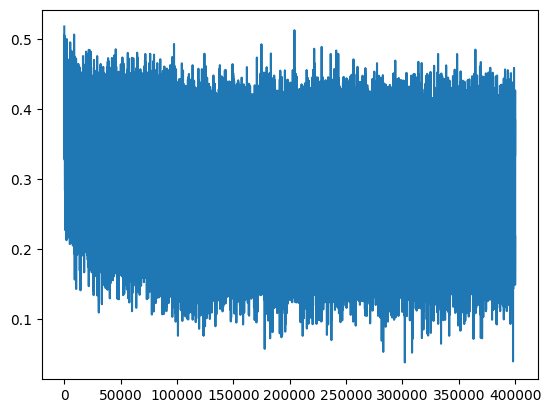

In [356]:
plt.plot(stepi, lossi)


```
default:
block_size: 3
t_d: 10
W1_n: 200

default:                      | loss_tr = 2.1146, loss_va = 2.1766, diff ~= .06
default:                      | loss_tr = 2.1171, loss_va = 2.1602, diff ~= .04

block_size: 5                 | loss_tr = 2.1945, loss_va = 2.2241, diff ~= .03
t_d: 11                       | loss_tr = 2.1093, loss_va = 2.1637, diff ~= .05
t_d: 12                       | loss_tr = 2.1064, loss_va = 2.1575, diff ~= .05
t_d: 12                       | loss_tr = 2.1047, loss_va = 2.1581, diff ~= .05
t_d: 12 +  W1_n: 205          | 
t_d: 15                       | loss_tr = 2.0893, loss_va = 2.1709, diff ~= .08
t_d: 20                       | loss_tr = 2.0680, loss_va = 2.1646, diff ~= .1
t_d: 20 + 0.1 smoothing       | loss_tr = 2.1085, loss_va = 2.1668, diff ~= .06
default + 0.1 smoothing       | loss_tr = 2.1890, loss_va = 2.2265, diff ~= .04
default + 0.01 smoothing      | loss_tr = 2.1252, loss_va = 2.1766, diff ~= .05
W1_n: 400 + 0.01 smoothing    | loss_tr = 2.1061, loss_va = 2.2481, diff ~= .15
W1_n: 1000                    | loss_tr = 2.1061, loss_va = 2.2481, diff ~= .15
```


In [357]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, t_d*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9748, grad_fn=<NllLossBackward0>)

In [358]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, t_d*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0533, grad_fn=<NllLossBackward0>)

E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

suppose probabilities are uniform -- 1/27 for all
then likelihood given any outcome is uniform -- 1/27 for all
then negative log likelyhood given any outcome is uniform -- -log(1/27)

expected initial loss: 3.295836866004329

We should also set bias to zero.


2.13   | block_size: 3, t_d: 12
2.1143 | block_size: 4, t_d: 12
2.1133 | block_size: 5, t_d: 12
2.1188 | block_size: 5, t_d: 12
2.1124 | block_size: 5, t_d: 12

okay what if we do the same with the first layer?

In [359]:
# Exercise: derive generate code

def gen_word():
    context = [0] * block_size
    while True:
      emb = C[context[-block_size:]] # (1, 3, 2)
      emb[:, 2] = 10
      W1_ = W1.clone()
      # W1_[:,torch.randint(0, 200,(200,) )] *= 0 # picks a theme
      h = torch.tanh(emb.view(-1, t_d*block_size) @ W1_ + b1) # (block_size, 100)
      W2_ = W2.clone()
      # W2_[50] *= -3
      logits = h @ W2_ + b2 # (32, 27)
      # logits[0, stoi['l']] *= 2
      # logits[0, stoi['x']] *= 10
      # logits[0, stoi['q']] += 5
      # get probabilities
      probs = torch.softmax(logits, dim=1)
      # probs = 1 - probs
      iy = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
      if iy.item() == 0:
        break
      context = context + [iy.item()] # crop and append
    word = []
    for c in context[block_size:]:
      word.append(itos[c])
    return "".join(word)

for _ in range(500):
  print(gen_word())

aha
hhih
eha
hi
hehe
hyn
hyii
hi
hehe
hahyyi
hhie
ehyziyyy
hhithi
hehii
hahyiie
hahhi
yyi
hy
hi
ehye
hi
hyyekewyirehi
he
ehaye
iehhe
hha
ehywere
hi
hyahy
hehoyi
ihahdchae
hi
hayi
yehyyy
ha
he
he
hhoachyye
ehece
e
heyi
hi
hyke
hihicytaye
i
hehe
hhe
ahehehyyye
hehi
hyahi
hahe
hhyi
oiei
hehe
hihi
hehumi
iheta
eyieyi
hehyyy
he
he
hhyeyiyyei
hieu
ehi
hewheliyiahi
hhahy
hhu
hha
hehimota
hy
hyyii
hehahaahiyi
he
heheyeye
hhoyyuye
he
ha
hehryye
hahi
hihi
hyhyi
hy
iheco
aheity
he
hi
hya
hihiyike
hihcyi
hyhecy
he
ehiehi
ixoeeiyithycoti
ahoe
yeheii
heha
isosyeyi
hyehe

hiho
hyye
hehye
yy
heha
hyehe
hy
hehi
he
i
hihe
hhye
hieyieeyyihye
hiu
he
yhi
hhei
yye
ahawa
eheyice
hyawa
hyyekyyie
hihicy
hyeye
ihyye
he
hhahoye
ha
hyhe
heetkyiye
he
yehahahe
hehe
hyhehe
he
ha
hhyeedyyohiyi
hehuyi
haha
hyeko
hahahi
e
hi
yyeety
hehoye
hyhy
hehyyi
hihi
hehyyyie
yyye
hehe
huehiyyxehi
hy
hehieyyi
ieheyiiicy
hehye
hyhye
huetyyy
hihi
aha
hhye
hyice
ehaheyiyii
aheegyyre
heha
yorke
hihocyyyayeyi
hhye
hehyyiykete
hilikyehy

In [360]:
import numpy as np
-1 * np.log(1/27)

3.295836866004329

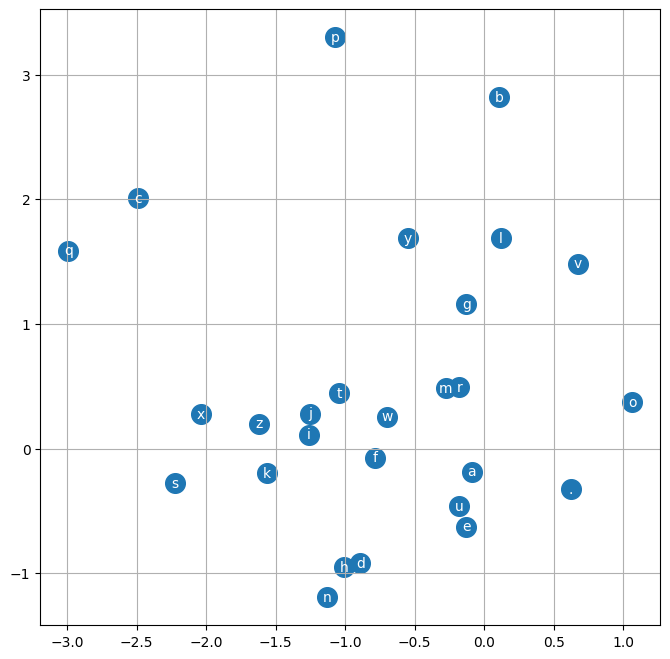

In [361]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

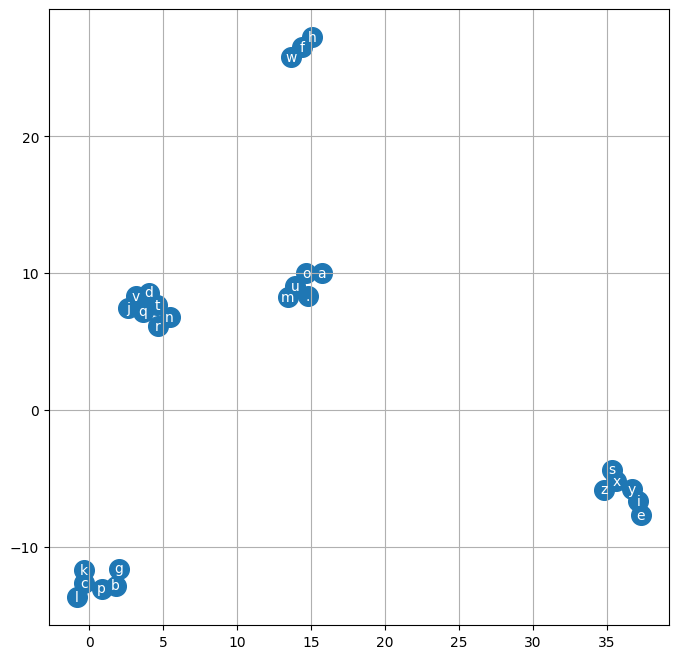

In [362]:
import umap
# visualize umapped embedding matrix C for all characters

C_r = umap.UMAP(n_components=2, n_neighbors=2, min_dist=1, metric="cosine").fit_transform(C.detach().numpy())


plt.figure(figsize=(8,8))
plt.scatter(C_r[:,0].data, C_r[:,1].data, s=200)
for i in range(C_r.shape[0]):
    plt.text(C_r[i,0].item(), C_r[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

tensor([[0.7228, 0.4868, 0.3885, 0.3776, 0.5786],
        [0.8731, 0.6647, 0.8390, 0.2564, 0.2770],
        [0.0468, 0.1764, 0.8774, 0.5026, 0.3332]])